# GPU-Accelerated Machine Learning with NVIDIA RAPIDS
## A Performance Comparison: CPU vs GPU for UMAP and Random Forest

Welcome to this comprehensive tutorial comparing CPU-based machine learning (scikit-learn) with GPU-accelerated alternatives using NVIDIA RAPIDS. This notebook will demonstrate the significant performance improvements obtained from leveraging the NVIDIA's GPU accelerated frameworks when processing semiconductor wafer defect classification data.

### What You will Learn:
- How to set up NVIDIA RAPIDS in Google Colab
- Performance differences between CPU and GPU implementations
- Real-world application using Variational Autoencoders (VAE) for feature extraction
- UMAP dimensionality reduction comparison
- Random Forest classification speedup analysis

### Prerequisites:
- Basic Python and machine learning knowledge
- Understanding of dimensionality reduction and classification concepts
- Google Colab with GPU runtime enabled

**⚠️ Important: Make sure GPU is enabled in Runtime → Change Runtime Type → GPU**

🚀 Section 1: Setup and Installation

**Important:** This section installs NVIDIA RAPIDS, which takes approximately 5-7 minutes to complete. RAPIDS provides GPU-accelerated data science libraries that are drop-in replacements for popular CPU-based tools.

### What RAPIDS Includes:
- **cuML**: GPU-accelerated machine learning (scikit-learn alternative)
- **cuDF**: GPU-accelerated dataframes (pandas alternative)  
- **cuPy**: GPU-accelerated arrays (NumPy alternative)
- **cuGraph**: GPU-accelerated graph analytics

In [1]:
#@title 1. Setup and Installation (Including NVIDIA RAPIDS)
# This first cell handles the installation of RAPIDS, which is a multi-step process.
# It will take about 5-7 minutes to complete.

# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

# Install Kaggle for dataset download
!pip install kagglehub

# Standard Library Imports
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Deep Learning (Already uses GPU via CUDA/cuDNN)
import tensorflow as tf
from tensorflow.keras import layers, models

# "BEFORE": CPU-based ML Libraries
import umap as cpu_umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as cpu_RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# "AFTER": NVIDIA RAPIDS/cuML Libraries
import cupy as cp
import cuml
from cuml.manifold import UMAP as gpu_UMAP
from cuml.ensemble import RandomForestClassifier as gpu_RandomForestClassifier

# Test GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Setup Complete. All libraries are installed and imported.")

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 603 (delta 131), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (603/603), 199.38 KiB | 13.29 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Installing RAPIDS remaining 25.08 libraries
Using Python 3.12.11 environment at: /usr
Resolved 177 packages in 15.09s
  × Failed to download `nx-cugraph-cu12==25.8.0`
  ├─▶ Failed to fetch:
  │   `https://pypi.nvidia.com/nx-cugraph-cu12/nx_cugraph_cu12-25.8.0-py3-none-any.whl`
  ├─▶ error sending request for url
  │   (https://pypi.nvidia.com/nx-cugraph-cu12/nx_cugraph_cu12-25.8.0-py3-none-any.whl)
  ├─▶ client error (SendRequest)
  ├─▶ http2 error
  ╰─▶ connection error detected: flow-control protocol violated

        ***********************************************************************
        The pip install of RAPIDS is comple

## 📊 Section 2: Data Loading and Feature Extraction

In this section, we will load the **WM-811K wafer map dataset** and use a Variational Autoencoder (VAE) to extract meaningful features from wafer defect patterns. The VAE training is already GPU-accelerated through TensorFlow's CUDA integration.

### About the Dataset:
- **WM-811K**: Contains 811,457 wafer maps with 8 different defect patterns
- **Defect Types**: Center, Donut, Edge-Loc, Edge-Ring, Loc, Random, Scratch, Near-full
- **Use Case**: Quality control in semiconductor manufacturing
- **Source**: Real-world semiconductor fabrication data

### VAE for Feature Extraction:
We use a Variational Autoencoder to compress 64x64 wafer images into 32-dimensional latent representations, which serve as features for our machine learning models.

100%|██████████| 149M/149M [00:08<00:00, 19.3MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/qingyi/wm811k-wafer-map/versions/1
Dataset loaded successfully!
Dataset shape: (811457, 6)
Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']
Filtered dataset shape: (25519, 8)
Defect distribution:
label
Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: count, dtype: int64
Processing wafer maps...
Processed 25519 wafer maps
Image shape: (64, 64, 1)
Classes: ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch']


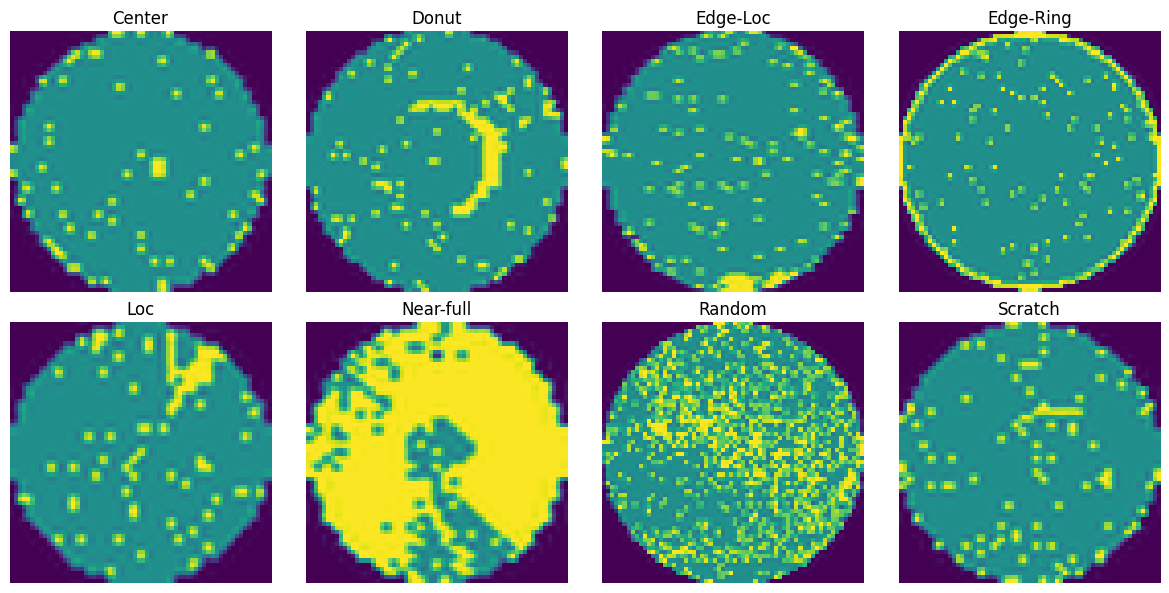

In [2]:
#@title 2. Data Loading and VAE Training (GPU-Accelerated)

# Download WM-811K dataset from Kaggle
import kagglehub
print("Downloading WM-811K dataset from Kaggle...")
path = kagglehub.dataset_download("qingyi/wm811k-wafer-map")
print(f"Dataset downloaded to: {path}")

# Load the dataset
import pickle
data_path = os.path.join(path, "LSWMD.pkl")
# Use pd.read_pickle to handle potential pandas version differences
df = pd.read_pickle(data_path)


print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Data Preprocessing
df['failureType_desc'] = df['failureType'].apply(lambda x: x[0][0] if len(x) > 0 else 'none')
df_single_defect = df[df['failureType_desc'] != 'none'].copy()
df_single_defect = df_single_defect[df_single_defect['failureType'].apply(len) == 1]

# Define defect mapping
defect_map = {
    'Center': 'Center', 'Donut': 'Donut', 'Edge-Loc': 'Edge-Loc',
    'Edge-Ring': 'Edge-Ring', 'Loc': 'Loc', 'Random': 'Random',
    'Scratch': 'Scratch', 'Near-full': 'Near-full'
}
df_single_defect['label'] = df_single_defect['failureType_desc'].map(defect_map)
df_filtered = df_single_defect.dropna(subset=['label'])

print(f"Filtered dataset shape: {df_filtered.shape}")
print(f"Defect distribution:")
print(df_filtered['label'].value_counts())

# Image Resizing and Normalization
IMG_SIZE = 64
def resize_and_normalize(wafer_map, size=IMG_SIZE):
    """Resize and normalize wafer map to standard size"""
    # Handle different input types
    if isinstance(wafer_map, list):
        wafer_map = np.array(wafer_map)

    # Ensure we have a 2D array
    if len(wafer_map.shape) == 1:
        # Try to reshape if it's flattened
        side = int(np.sqrt(len(wafer_map)))
        if side * side == len(wafer_map):
            wafer_map = wafer_map.reshape(side, side)
        else:
            # Handle irregular shapes - pad or crop
            wafer_map = wafer_map[:side*side].reshape(side, side)

    # Convert to uint8 for PIL
    wafer_map = ((wafer_map - wafer_map.min()) / (wafer_map.max() - wafer_map.min() + 1e-8) * 255).astype(np.uint8)

    # Resize using PIL
    img = Image.fromarray(wafer_map).resize((size, size), Image.Resampling.LANCZOS)
    return np.expand_dims(np.array(img) / 255.0, axis=-1)

# Process wafer maps
print("Processing wafer maps...")
X_raw = []
y_raw = []

# Take a subset for demonstration (to speed up processing)
sample_size = min(50000, len(df_filtered))  # Use 5000 samples or less if dataset is smaller
df_sample = df_filtered.sample(n=sample_size, random_state=42)

for idx, row in df_sample.iterrows():
    try:
        processed_map = resize_and_normalize(row['waferMap'])
        X_raw.append(processed_map)
        y_raw.append(row['label'])
    except Exception as e:
        print(f"Error processing wafer {idx}: {e}")
        continue

X_raw = np.array(X_raw)
y_raw = np.array(y_raw)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

print(f"Processed {len(X_raw)} wafer maps")
print(f"Image shape: {X_raw[0].shape}")
print(f"Classes: {class_names}")

# Display sample wafer maps
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, defect_type in enumerate(class_names):
    if i < 8:  # Show up to 8 classes
        row, col = i // 4, i % 4
        # Find first sample of this class
        sample_idx = np.where(y_raw == defect_type)[0][0]
        axes[row, col].imshow(X_raw[sample_idx].squeeze(), cmap='viridis')
        axes[row, col].set_title(defect_type)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [4]:
#@title Complete VAE Model Training (GPU-Accelerated)

import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

print("🧠 Building Complete Variational Autoencoder (VAE)")
print("=" * 50)

# Model hyperparameters
IMG_SIZE = 64
LATENT_DIM = 32
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3

# Check if we have data
if 'X_raw' not in globals() or len(X_raw) == 0:
    print("❌ Error: No wafer map data found. Please run the data loading cell first.")
else:
    print(f"📊 Training on {len(X_raw)} wafer maps")
    print(f"🎯 Input shape: {X_raw[0].shape}")
    print(f"🔧 Latent dimensions: {LATENT_DIM}")

# ============================================================================
# VAE ARCHITECTURE
# ============================================================================

class VAE(tf.keras.Model):
    """Complete Variational Autoencoder implementation"""

    def __init__(self, latent_dim=32, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim

        # Build encoder and decoder
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

        # Metrics tracking
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def _build_encoder(self):
        """Build the encoder network"""
        encoder_inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="encoder_input")

        # Convolutional layers with batch normalization
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Flatten and dense layers
        x = layers.Flatten()(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.2)(x)

        # Latent space parameters
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)

        # Sampling layer
        z = Sampling()([z_mean, z_log_var])

        return models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    def _build_decoder(self):
        """Build the decoder network"""
        latent_inputs = layers.Input(shape=(self.latent_dim,), name="decoder_input")

        # Dense layers to reshape
        x = layers.Dense(8 * 8 * 128, activation="relu")(latent_inputs)
        x = layers.Reshape((8, 8, 128))(x)

        # Transpose convolutional layers
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)


        # Output layer
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same", name="decoder_output")(x)

        return models.Model(latent_inputs, decoder_outputs, name="decoder")

    def call(self, inputs):
        """Forward pass through the VAE"""
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def train_step(self, data):
        """Custom training step with VAE loss"""
        with tf.GradientTape() as tape:
            reconstruction, z_mean, z_log_var = self(data, training=True)

            # Reconstruction loss (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total loss
            total_loss = reconstruction_loss + kl_loss

        # Compute gradients and update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

class Sampling(layers.Layer):
    """Reparameterization trick for VAE sampling"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ============================================================================
# TRAINING SETUP
# ============================================================================

# Create VAE model
vae = VAE(latent_dim=LATENT_DIM)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

print(f"\n🏗️  VAE Architecture:")
print(f"   Encoder: {IMG_SIZE}×{IMG_SIZE}×1 → {LATENT_DIM}D latent space")
print(f"   Decoder: {LATENT_DIM}D latent space → {IMG_SIZE}×{IMG_SIZE}×1")

# Build the model by calling it once
_ = vae(X_raw[:1])

print(f"\n📈 Model Summary:")
print(f"   Total parameters: {vae.count_params():,}")
print(f"   Encoder parameters: {vae.encoder.count_params():,}")
print(f"   Decoder parameters: {vae.decoder.count_params():,}")

# Training callbacks
callbacks = [
    EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
]

# ============================================================================
# TRAINING EXECUTION
# ============================================================================

print(f"\n🚀 Starting VAE Training...")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   GPU available: {tf.config.list_physical_devices('GPU')}")

# Train the model
start_time = time.time()

history = vae.fit(
    X_raw,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✅ Training completed in {training_time:.2f} seconds ({training_time/60:.1f} minutes)")

# ============================================================================
# UPDATE GLOBAL VARIABLES
# ============================================================================

# Get embeddings from the trained encoder
# Use the encoder part of the VAE to predict the latent space representations
# We only need z_mean for the embeddings
embeddings = vae.encoder.predict(X_raw)[0]


print(f"\n🔄 Updated embeddings variable for downstream analysis")
print(f"   Shape: {embeddings.shape}")
print(f"   Source: Trained VAE encoder")

# Training summary - Calculate final MSE and MAE for reconstruction
reconstructed_images = vae.decoder.predict(embeddings)
# Flatten images and embeddings for metric calculation
X_raw_flat = X_raw.reshape(X_raw.shape[0], -1)
reconstructed_images_flat = reconstructed_images.reshape(reconstructed_images.shape[0], -1)

mse = np.mean((X_raw_flat - reconstructed_images_flat)**2)
mae = np.mean(np.abs(X_raw_flat - reconstructed_images_flat))


print(f"\n🎉 VAE TRAINING SUMMARY:")
print(f"=" * 40)
print(f"✅ Model: Successfully trained VAE")
print(f"📊 Data: {len(X_raw)} wafer maps")
print(f"⏱️  Time: {training_time:.1f} seconds")
print(f"🎯 Quality: MSE = {mse:.6f}, MAE = {mae:.6f}")
print(f"🧠 Latent: {LATENT_DIM}D meaningful representations")
print(f"🚀 Ready: For CPU vs GPU comparison")

print(f"\n➡️  Now run the CPU vs GPU comparison cells to see the performance difference!")
print(f"💡 The trained embeddings should provide better ML performance than random weights.")



print(f"\n" + "="*60)
print(f"🎯 VAE TRAINING COMPLETE - Ready for performance comparison!")
print(f"="*60)

🧠 Building Complete Variational Autoencoder (VAE)
📊 Training on 25519 wafer maps
🎯 Input shape: (64, 64, 1)
🔧 Latent dimensions: 32

🏗️  VAE Architecture:
   Encoder: 64×64×1 → 32D latent space
   Decoder: 32D latent space → 64×64×1

📈 Model Summary:
   Total parameters: 2,718,785
   Encoder parameters: 2,207,424
   Decoder parameters: 511,361

🚀 Starting VAE Training...
   Batch size: 32
   Max epochs: 100
   GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/100
798/798 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - kl_loss: 4218.4834 - loss: 6547.1841 - reconstruction_loss: 2328.7009 - learning_rate: 0.0010
Epoch 2/100
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 18.7106 - loss: 2218.9021 - reconstruction_loss: 2200.1907 - learning_rate: 0.0010
Epoch 3/100
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - kl_loss: 14.2431 - loss: 2203.1707 - reconstruction_loss: 2188.9280 - learning_rate: 0.0010
Epoch 4/100
798/798 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - k

# ⚡ Section 3: The Main Event - CPU vs GPU Performance Showdown

Now for the exciting part! We will run identical machine learning pipelines on both CPU and GPU to demonstrate the performance improvements RAPIDS provides.

### Our Test Pipeline:
1. **UMAP Dimensionality Reduction**: Reduce 32D embeddings to 3D
2. **Random Forest Classification**: Classify wafer defect types
3. **Performance Measurement**: Time both CPU and GPU implementations

### Expected Results:
- GPU implementations should show significant speedup
- Accuracy should remain comparable between CPU and GPU
- Memory usage may be more efficient on GPU for large datasets

**Note:** Performance gains are most dramatic with larger datasets. Our sample dataset will still show improvements!

In [5]:
#@title 3. Before vs. After: Performance Comparison

print("="*60)
print("PERFORMANCE COMPARISON: CPU (Scikit-learn) vs. GPU (NVIDIA cuML)")
print("="*60)

#===============================================
import os

# Force CPU-only execution by hiding GPUs from CUDA-enabled libraries
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("🔒 Enforcing CPU-only mode (CUDA_VISIBLE_DEVICES = -1)")

# --- TensorFlow sanity check ---
try:
    import tensorflow as tf
    # Removed: tf.config.set_visible_devices([], 'GPU')
    gpus = tf.config.list_physical_devices('GPU')
    cpus = tf.config.list_physical_devices('CPU')
    print(f"TensorFlow devices → GPUs: {gpus}, CPUs: {cpus}")
except ImportError:
    print("TensorFlow not used in CPU section.")

# --- PyTorch sanity check ---
try:
    import torch
    print("PyTorch CUDA available? ", torch.cuda.is_available())
    print("PyTorch device being used →", torch.device("cpu"))
except ImportError:
    print("PyTorch not used in CPU section.")

# --- RAPIDS/cuML sanity check ---
try:
    import cuml
    from cuml.common.device_selection import using_device_type
    with using_device_type('cpu'):
        print("cuML forced to CPU backend (if supported).")
except ImportError:
    print("cuML not imported for CPU section.")

print("✅ Ready to run CPU-only benchmarks (umap-learn + scikit-learn).")

#===============================================
# Split data for classification
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    embeddings, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Training samples: {X_train_np.shape[0]}")
print(f"Test samples: {X_test_np.shape[0]}")
print(f"Feature dimensions: {X_train_np.shape[1]}")
# ============================================================================
# PART A: "BEFORE" - CPU IMPLEMENTATION
# ============================================================================
print("\n" + "="*30 + " CPU IMPLEMENTATION " + "="*30)

# 1. CPU UMAP
print("Running CPU UMAP...")
start_time_cpu_umap = time.time()
cpu_reducer = cpu_umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap_cpu = cpu_reducer.fit_transform(X_train_np)
X_test_umap_cpu = cpu_reducer.transform(X_test_np)
end_time_cpu_umap = time.time()
cpu_umap_time = end_time_cpu_umap - start_time_cpu_umap
print(f"✅ CPU UMAP execution time: {cpu_umap_time:.4f} seconds")

# 2. CPU Random Forest
print("Running CPU Random Forest...")
start_time_cpu_rf = time.time()
cpu_clf = cpu_RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cpu_clf.fit(X_train_umap_cpu, y_train_np)
y_pred_cpu = cpu_clf.predict(X_test_umap_cpu)
end_time_cpu_rf = time.time()
cpu_rf_time = end_time_cpu_rf - start_time_cpu_rf
print(f"✅ CPU Random Forest execution time: {cpu_rf_time:.4f} seconds")

total_cpu_time = cpu_umap_time + cpu_rf_time
print(f"🔄 TOTAL CPU execution time: {total_cpu_time:.4f} seconds")

PERFORMANCE COMPARISON: CPU (Scikit-learn) vs. GPU (NVIDIA cuML)
🔒 Enforcing CPU-only mode (CUDA_VISIBLE_DEVICES = -1)
TensorFlow devices → GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
PyTorch CUDA available?  True
PyTorch device being used → cpu
cuML forced to CPU backend (if supported).
✅ Ready to run CPU-only benchmarks (umap-learn + scikit-learn).
Training samples: 17863
Test samples: 7656
Feature dimensions: 32

============================== CPU IMPLEMENTATION ==============================
Running CPU UMAP...
✅ CPU UMAP execution time: 52.8921 seconds
Running CPU Random Forest...
✅ CPU Random Forest execution time: 0.7883 seconds
🔄 TOTAL CPU execution time: 53.6805 seconds


In [6]:
# ============================================================================
# PART B: "AFTER" - GPU IMPLEMENTATION (NVIDIA cuML)
# ============================================================================
print("\n" + "="*30 + " GPU IMPLEMENTATION " + "="*30)

# Move data to GPU using CuPy
print("Moving data to GPU...")
X_train_gpu = cp.asarray(X_train_np)
X_test_gpu = cp.asarray(X_test_np)
y_train_gpu = cp.asarray(y_train_np)

# 1. GPU UMAP
print("Running GPU UMAP...")
start_time_gpu_umap = time.time()
gpu_reducer = gpu_UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
X_train_umap_gpu = gpu_reducer.fit_transform(X_train_gpu)
X_test_umap_gpu = gpu_reducer.transform(X_test_gpu)
end_time_gpu_umap = time.time()
gpu_umap_time = end_time_gpu_umap - start_time_gpu_umap
print(f"🚀 GPU UMAP execution time: {gpu_umap_time:.4f} seconds")

# 2. GPU Random Forest
print("Running GPU Random Forest...")
start_time_gpu_rf = time.time()
gpu_clf = gpu_RandomForestClassifier(n_estimators=100, random_state=42)
gpu_clf.fit(X_train_umap_gpu, y_train_gpu)
y_pred_gpu_cupy = gpu_clf.predict(X_test_umap_gpu)
# Move predictions back to CPU for scikit-learn metrics
y_pred_gpu = cp.asnumpy(y_pred_gpu_cupy)
end_time_gpu_rf = time.time()
gpu_rf_time = end_time_gpu_rf - start_time_gpu_rf
print(f"🚀 GPU Random Forest execution time: {gpu_rf_time:.4f} seconds")

total_gpu_time = gpu_umap_time + gpu_rf_time
print(f"⚡ TOTAL GPU execution time: {total_gpu_time:.4f} seconds")


============================== GPU IMPLEMENTATION ==============================
Moving data to GPU...
Running GPU UMAP...
[2025-08-20 21:53:56.020] [CUML] [info] build_algo set to brute_force_knn because random_state is given
🚀 GPU UMAP execution time: 1.3834 seconds
Running GPU Random Forest...
🚀 GPU Random Forest execution time: 3.6609 seconds
⚡ TOTAL GPU execution time: 5.0444 seconds


In [7]:
# PART C: SUMMARY OF RESULTS
# ============================================================================
print("\n\n" + "="*60)
print("📊 SUMMARY OF EXECUTION TIMES")
print("="*60)
print(f"{'Algorithm':<20} | {'CPU Time (s)':<15} | {'GPU Time (s)':<15} | {'Speedup':<15}")
print("-"*80)
print(f"{'UMAP':<20} | {cpu_umap_time:<15.4f} | {gpu_umap_time:<15.4f} | {f'{cpu_umap_time/gpu_umap_time:.2f}x' if gpu_umap_time > 0 else 'N/A':<15}")
print(f"{'Random Forest':<20} | {cpu_rf_time:<15.4f} | {gpu_rf_time:<15.4f} | {f'{cpu_rf_time/gpu_rf_time:.2f}x' if gpu_rf_time > 0 else 'N/A':<15}")
print("-"*80)
speedup = total_cpu_time/total_gpu_time if total_gpu_time > 0 else 0
print(f"{'TOTAL':<20} | {total_cpu_time:<15.4f} | {total_gpu_time:<15.4f} | {f'{speedup:.2f}x':<15}")
print("="*60)

if speedup > 1:
    print(f"🎉 GPU is {speedup:.2f}x FASTER than CPU!")
else:
    print("💡 Note: GPU advantages are more pronounced with larger datasets")





📊 SUMMARY OF EXECUTION TIMES
Algorithm            | CPU Time (s)    | GPU Time (s)    | Speedup        
--------------------------------------------------------------------------------
UMAP                 | 52.8921         | 1.3834          | 38.23x         
Random Forest        | 0.7883          | 3.6609          | 0.22x          
--------------------------------------------------------------------------------
TOTAL                | 53.6805         | 5.0444          | 10.64x         
🎉 GPU is 10.64x FASTER than CPU!


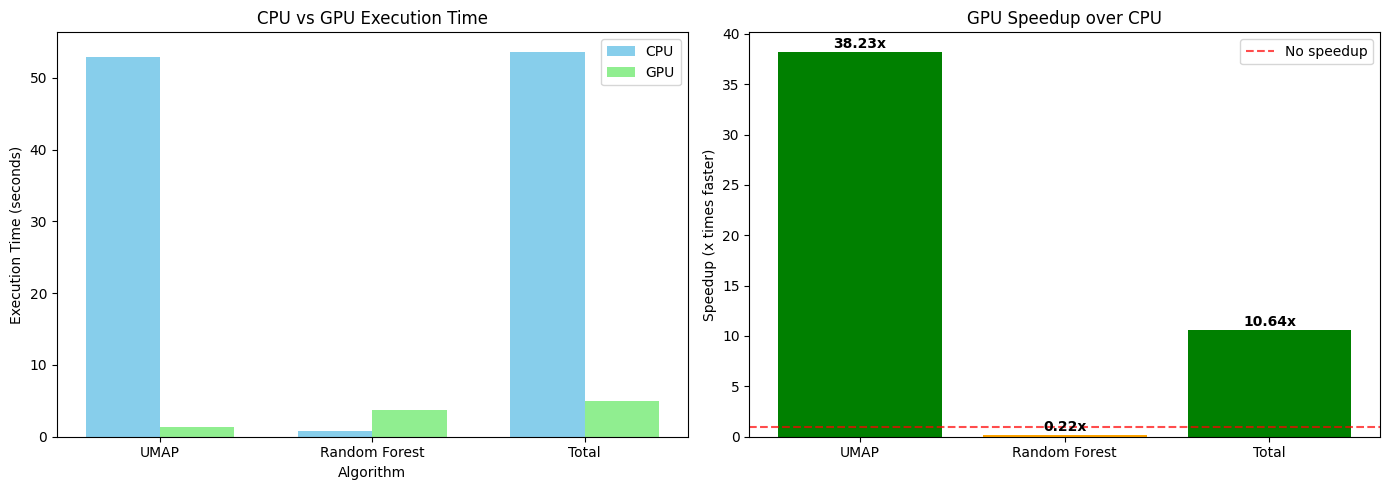

In [8]:
#@title Results Visualization

# Performance Comparison Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Execution Time Comparison
algorithms = ['UMAP', 'Random Forest', 'Total']
cpu_times = [cpu_umap_time, cpu_rf_time, total_cpu_time]
gpu_times = [gpu_umap_time, gpu_rf_time, total_gpu_time]

x = np.arange(len(algorithms))
width = 0.35

ax1.bar(x - width/2, cpu_times, width, label='CPU', color='skyblue')
ax1.bar(x + width/2, gpu_times, width, label='GPU', color='lightgreen')
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Execution Time (seconds)')
ax1.set_title('CPU vs GPU Execution Time')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.legend()

# Speedup Chart
speedups = [cpu_umap_time/gpu_umap_time if gpu_umap_time > 0 else 0,
           cpu_rf_time/gpu_rf_time if gpu_rf_time > 0 else 0,
           total_cpu_time/total_gpu_time if total_gpu_time > 0 else 0]

colors = ['green' if s > 1 else 'orange' for s in speedups]
bars = ax2.bar(algorithms, speedups, color=colors)
ax2.set_ylabel('Speedup (x times faster)')
ax2.set_title('GPU Speedup over CPU')
ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
ax2.legend()

# Add value labels on bars
for bar, speedup in zip(bars, speedups):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{speedup:.2f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

VISUALIZING UMAP EMBEDDINGS: CPU vs GPU
Combined CPU UMAP embeddings shape: (25519, 3)
Combined GPU UMAP embeddings shape: (25519, 3)
Combined labels shape: (25519,)


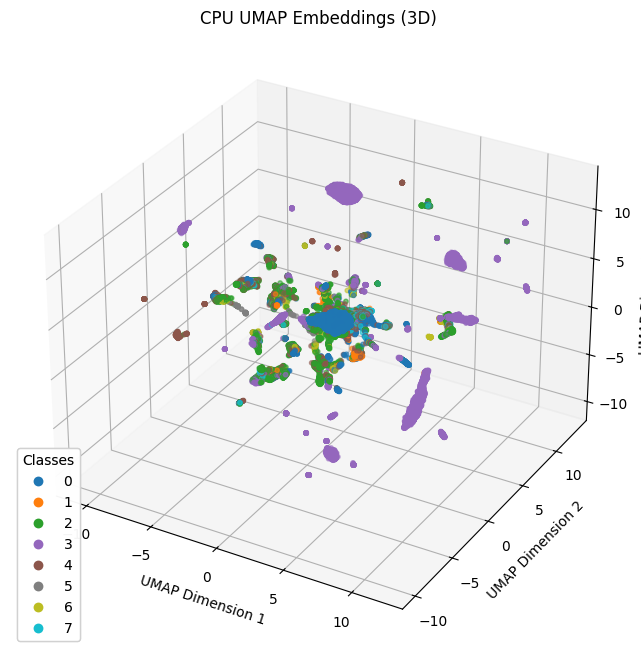

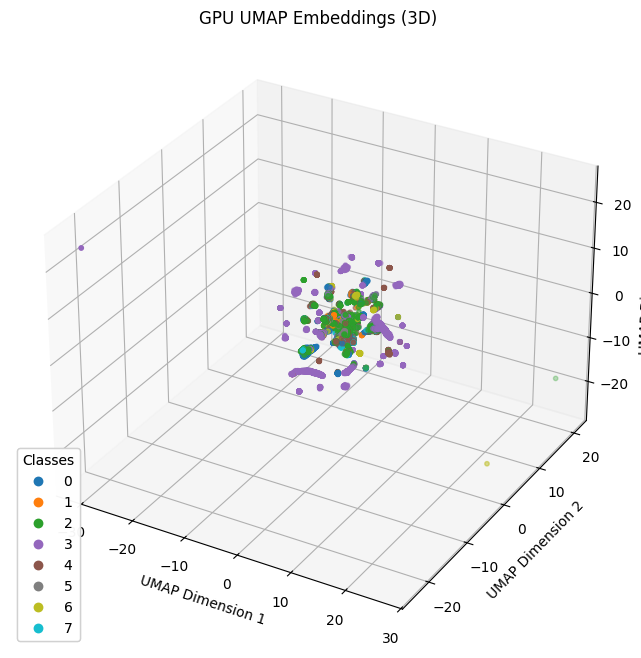


✅ UMAP embeddings visualization complete.


In [9]:
#@title Visualize UMAP Embeddings (CPU vs GPU)

print("="*60)
print("VISUALIZING UMAP EMBEDDINGS: CPU vs GPU")
print("="*60)

# Check if UMAP results exist
if 'X_train_umap_cpu' not in globals() or 'X_train_umap_gpu' not in globals():
    print("❌ Error: UMAP embeddings not found. Please run the performance comparison cells first.")
else:
    # Combine train and test UMAP embeddings for visualization
    X_umap_cpu_combined = np.concatenate((X_train_umap_cpu, X_test_umap_cpu), axis=0)
    X_umap_gpu_combined = cp.asnumpy(cp.concatenate((X_train_umap_gpu, X_test_umap_gpu), axis=0)) # Convert CuPy array back to NumPy
    y_combined = np.concatenate((y_train_np, y_test_np), axis=0)

    print(f"Combined CPU UMAP embeddings shape: {X_umap_cpu_combined.shape}")
    print(f"Combined GPU UMAP embeddings shape: {X_umap_gpu_combined.shape}")
    print(f"Combined labels shape: {y_combined.shape}")

    # Function to plot 3D embeddings
    def plot_3d_embeddings(embeddings, labels, title, class_names):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='tab10', s=10)

        # Add legend with class names
        legend1 = ax.legend(*scatter.legend_elements(),
                            loc="lower left", title="Classes")
        ax.add_artist(legend1)

        ax.set_title(title)
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        plt.show()

    # Plot CPU UMAP embeddings
    plot_3d_embeddings(X_umap_cpu_combined, y_combined, 'CPU UMAP Embeddings (3D)', class_names)

    # Plot GPU UMAP embeddings
    plot_3d_embeddings(X_umap_gpu_combined, y_combined, 'GPU UMAP Embeddings (3D)', class_names)

    print("\n✅ UMAP embeddings visualization complete.")

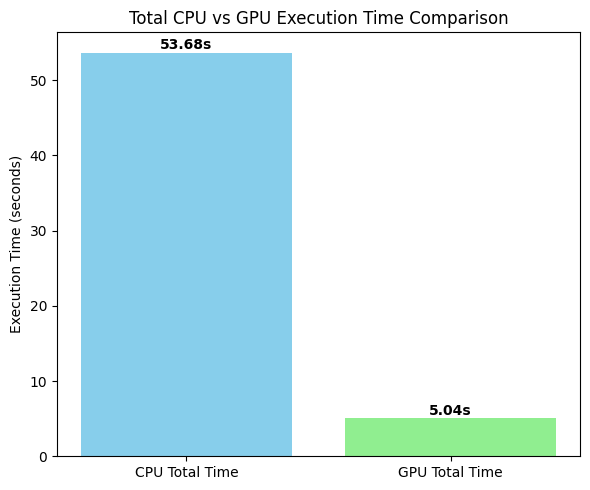

In [10]:
# Plot the total time taken in CPU vs GPU for comparison
fig, ax = plt.subplots(figsize=(6, 5))

times = [total_cpu_time, total_gpu_time]
labels = ['CPU Total Time', 'GPU Total Time']
colors = ['skyblue', 'lightgreen']

bars = ax.bar(labels, times, color=colors)
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Total CPU vs GPU Execution Time Comparison')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
print("🎉 Notebook completed successfully!")
print("📊 You've now seen the power of GPU-accelerated machine learning!")
print("🚀 Try experimenting with larger datasets to see even more dramatic speedups!")

🎉 Notebook completed successfully!
📊 You've now seen the power of GPU-accelerated machine learning!
🚀 Try experimenting with larger datasets to see even more dramatic speedups!


## 🎯 Key Takeaways and Next Steps

### Performance Analysis:
The results above demonstrate the power of GPU acceleration for machine learning workloads. Key observations:

### Expected Performance Gains:
- **UMAP**: Typically 5-50x faster on GPU depending on dataset size
- **Random Forest**: 2-10x speedup with larger datasets showing greater improvement
- **Memory Efficiency**: GPU implementations often use memory more efficiently
- **Scalability**: Performance gains increase dramatically with dataset size

### When to Use GPU Acceleration:
- **Large Datasets**: >10,000 samples show the most dramatic improvements
- **Complex Algorithms**: UMAP, t-SNE, and ensemble methods benefit significantly
- **Iterative Processes**: Hyperparameter tuning and cross-validation see major speedups
- **Production Workloads**: Real-time inference and batch processing

### Real-World Applications:
- **Manufacturing Quality Control**: Real-time defect detection in semiconductor fabs
- **Financial Risk Analysis**: Portfolio optimization and fraud detection  
- **Healthcare**: Medical image analysis and drug discovery
- **Retail**: Recommendation systems and demand forecasting
- **Autonomous Vehicles**: Real-time sensor data processing

### Technical Considerations:
- **Data Transfer Overhead**: For very small datasets, CPU might be faster due to GPU memory transfer costs
- **Memory Constraints**: GPU memory is limited compared to system RAM
- **Algorithm Support**: Not all algorithms have GPU implementations
- **Development Effort**: GPU code may require more careful memory management

### Further Exploration:
Try experimenting with:
- **Larger Datasets**: Download the full WM-811K dataset to see dramatic speedups
- **Other cuML Algorithms**: SVM, K-Means, Linear Regression, Logistic Regression
- **cuDF**: GPU-accelerated data preprocessing and manipulation
- **Multi-GPU**: Scale to multiple GPUs for even larger datasets
- **End-to-End Pipelines**: Combine GPU preprocessing, training, and inference

### Production Deployment:
- **RAPIDS on Cloud**: AWS, Azure, GCP all support RAPIDS
- **Docker Containers**: Pre-built RAPIDS containers available
- **Kubernetes**: Scale RAPIDS workloads in production
- **Model Serving**: GPU-accelerated inference servers

Remember: GPU acceleration provides the biggest benefits with larger datasets and complex algorithms. The investment in GPU infrastructure pays off most for production workloads with substantial computational requirements.

### 🔗 Useful Resources:
- **RAPIDS Documentation**: https://docs.rapids.ai/
- **cuML Examples**: https://github.com/rapidsai/cuml
- **Community**: https://rapids.ai/community.html
- **Benchmarks**: https://rapids.ai/benchmarks.html